In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
import h5py
import numpy as np
import seaborn as sn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib as mpl
from pathlib import Path
import sys

from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve

# import custom functions from src folder
module_path = str(Path.cwd() / "../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from SequentialNet import SequentialNet
from machine_learning import *
from util import *

In [72]:
color = ["#e41a1c", "#377eb8"]

### "Calibration" of analytical probabilities

In [48]:
# Setup

#Data constants
R2 = 3
k_red = 7
k_blue = 3
R1_min = 6
scale = 1
vary_a1 = False
vary_R2 = False
p_red = 0.5
polar = False
tag = f'r2_{R2}_kr{k_red}_kb{k_blue}_r1min{R1_min}_s{scale}_vary_r2_{vary_R2}_vary_a1_{vary_a1}_pRed_{p_red}'

# Data labels
y_labels = ["red", "blue"]
if polar:
    x_labels = ["r_x", "a_x"]
else:
    x_labels = ["x1", "x2"]

# Read files
testfile = f"analytical_solution_test_n_10000_{tag}_nxMC_200_nr1MC_100"
test_df = pd.read_csv(f"../analytical/results/{testfile}.csv")


In [121]:
def process(df):
    df["red"] = df["P_red_given_x"]
    df["blue"] = df["P_blue_given_x"]

    df["Inferred_color"] = df[["red", "blue"]].idxmax(axis=1)
    df["Inferred_confidence"] = df[["red", "blue"]].max(axis=1)
    df["Truth"] = df["color"]
    df["Truth_value"] = df["class"]

    df_copy = df.copy()
    df["Inferred_value"] = 0
    mask = df_copy["Inferred_color"] == "blue"
    df.loc[mask, "Inferred_value"] = 1
    # Too lazy to think
    df_copy = df.copy()
    df["Correctness"] = 0
    mask = df["Inferred_value"] == df["Truth_value"]
    df.loc[mask, "Correctness"] = 1
    #for i in range(len(df)):
    #    if df["Inferred_value"][i] == df["Truth_value"][i]:
    #        df.loc[i, "Correctness"] = 1
    return df

In [122]:
test_df = process(test_df)
test_df

,color,x1,x2,a1,a2,r1,r2,r_x,a_x,class,...,P_red_given_x,P_blue_given_x,red,blue,Inferred_color,Truth,Truth_value,Inferred_confidence,Inferred_value,Correctness
0,red,4.637181,11.350187,0.935784,1.553757,11.837233,3,12.260921,1.182936,0,...,0.589898,0.410102,0.589898,0.410102,red,red,0,0.589898,0,1
1,red,10.042744,10.382106,0.682262,0.612850,11.887063,3,14.444543,0.802012,0,...,0.839372,0.160628,0.839372,0.160628,red,red,0,0.839372,0,1
2,blue,-5.605532,11.920284,1.943990,0.295500,10.273541,3,13.172515,2.010363,1,...,0.723147,0.276853,0.723147,0.276853,red,blue,1,0.723147,0,0
3,blue,-1.477669,-14.679668,4.577589,0.170343,11.788505,3,14.753853,4.612066,1,...,0.862314,0.137686,0.862314,0.137686,red,blue,1,0.862314,0,0
4,blue,-9.945727,8.379890,2.213879,1.781017,13.296149,3,13.005386,2.441433,1,...,0.700778,0.299222,0.700778,0.299222,red,blue,1,0.700778,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,red,0.596807,9.253463,1.318706,2.526894,11.560692,3,9.272689,1.506390,0,...,0.343304,0.656696,0.343304,0.656696,blue,red,0,0.656696,1,0
9996,blue,-6.404741,6.863661,1.997287,1.496279,8.674995,3,9.387787,2.321621,1,...,0.337806,0.662194,0.337806,0.662194,blue,blue,1,0.662194,1,1
9997,blue,-11.277142,2.093363,2.757517,0.865739,9.295702,3,11.469791,2.958053,1,...,0.490148,0.509852,0.490148,0.509852,blue,blue,1,0.509852,1,1
9998,red,8.927445,11.836816,0.898653,3.012991,17.796208,3,14.825974,0.924606,0,...,0.864278,0.135722,0.864278,0.135722,red,red,0,0.864278,0,1


### Calibration plots for varying number of datapoints

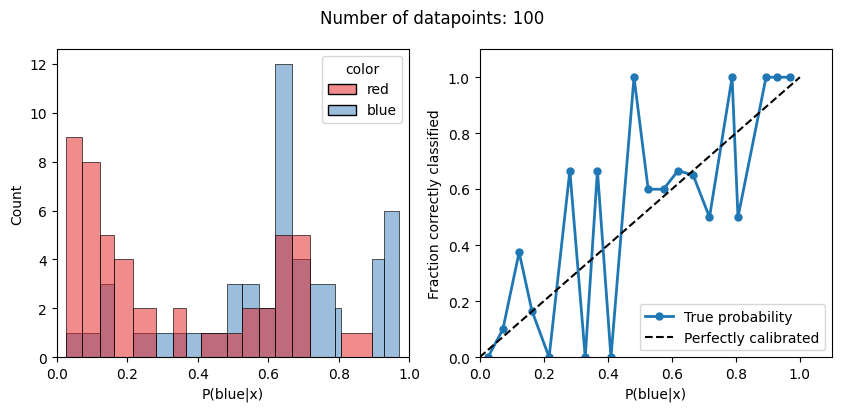

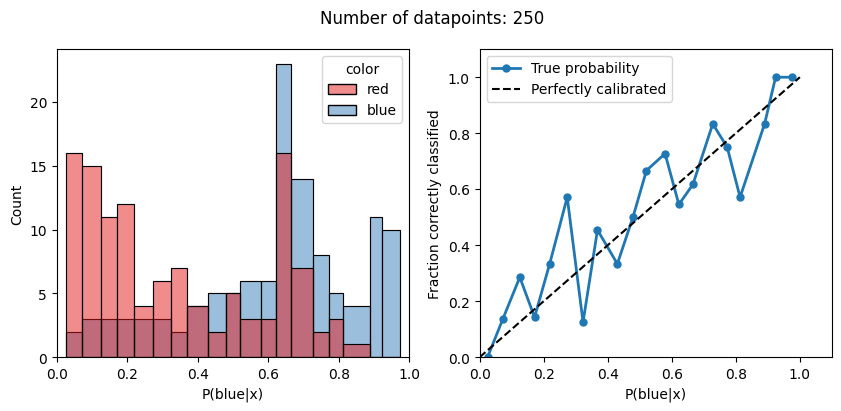

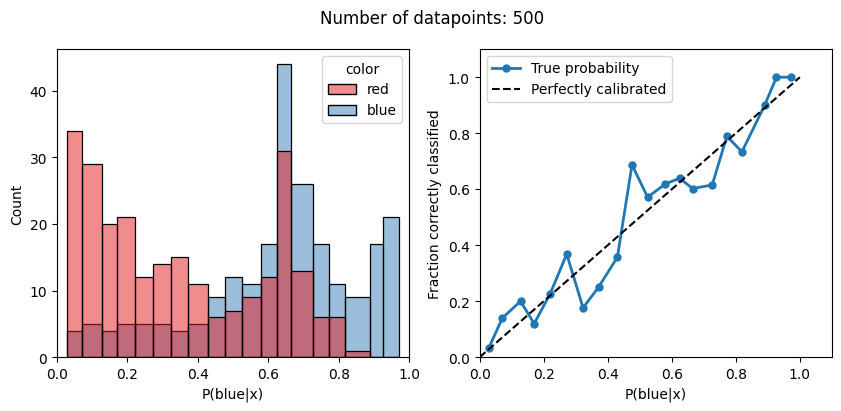

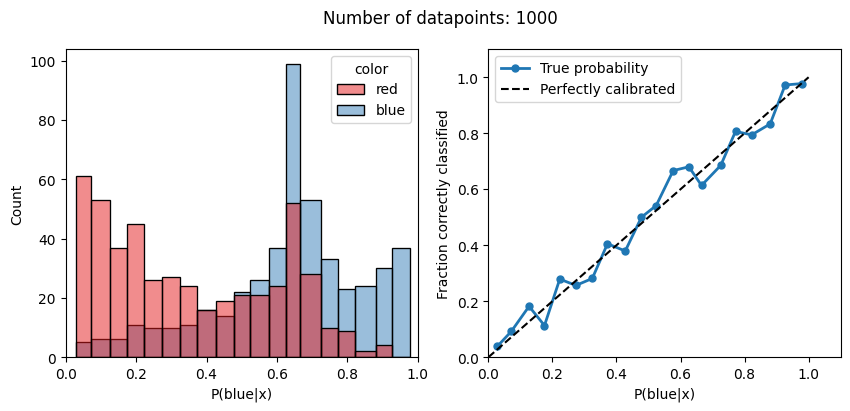

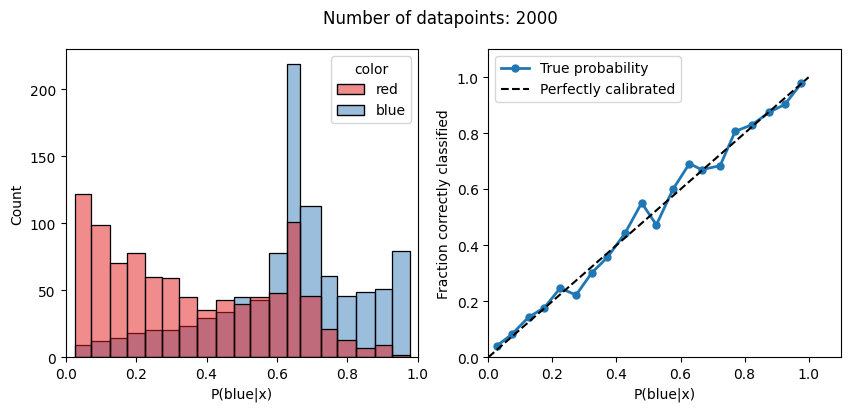

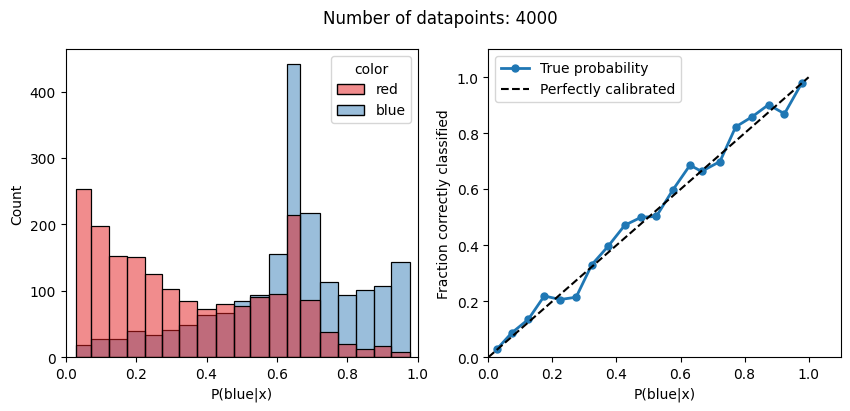

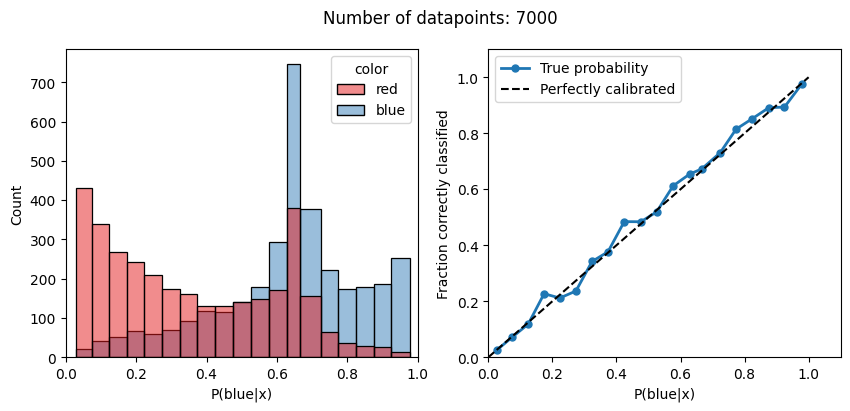

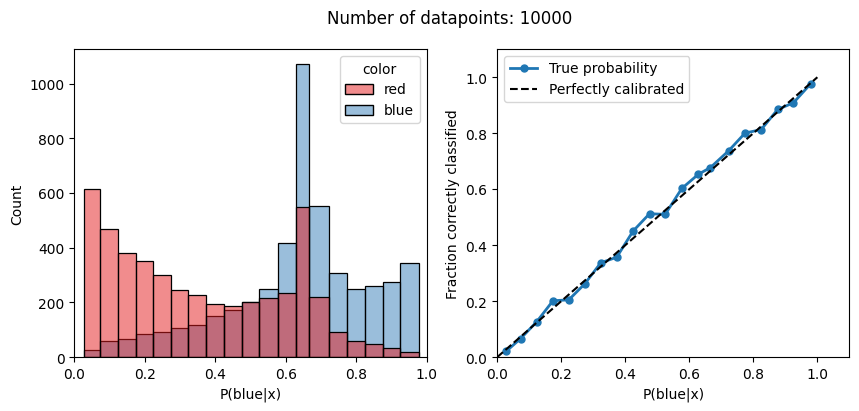

In [95]:

n_data = [100, 250, 500, 1000, 2000, 4000, 7000, 10000]

for i in range(len(n_data)):
    smaller_df = test_df[0:n_data[i]]
    prob_cal, prob_pred = calibration_curve(smaller_df["Truth_value"], smaller_df["blue"], n_bins=20, strategy="uniform")
    pred_bins=list(prob_pred)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    sn.histplot(smaller_df, x="blue", hue="color", ax=ax[0], stat="count", bins=pred_bins, palette=color)
    ax[0].set_xlim(0,1)
    ax[0].set_xlabel("P(blue|x)")
    ax[1].plot(prob_pred, prob_cal, linewidth=2, markersize=5, marker="o", label ="True probability")
    ax[1].set_xlim(0,1.1)
    ax[1].set_ylim(0,1.1)
    x = np.linspace(0, 1, 10)
    ax[1].plot(x, x, color="black", linestyle="--", label="Perfectly calibrated")
    ax[1].set_xlabel("P(blue|x)")
    ax[1].set_ylabel("Fraction correctly classified")
    ax[1].legend()
    fig.suptitle(f"Number of datapoints: {n_data[i]}")

### Calibration for varying number of bins

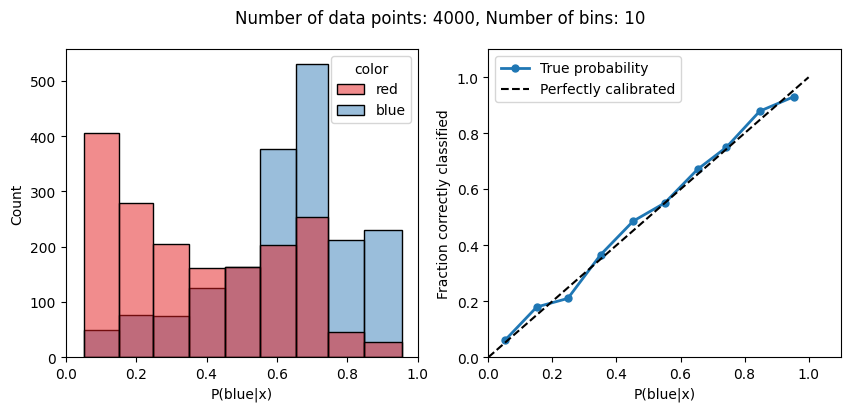

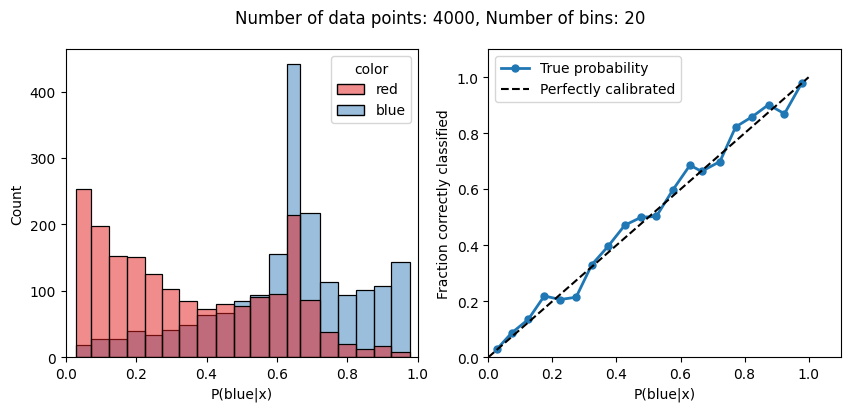

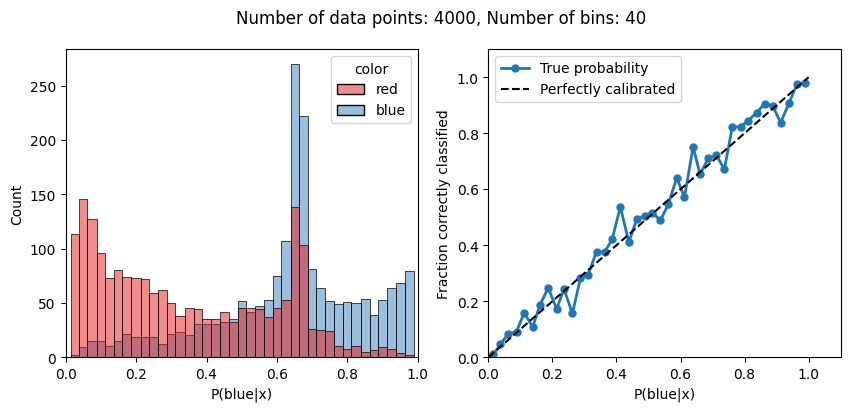

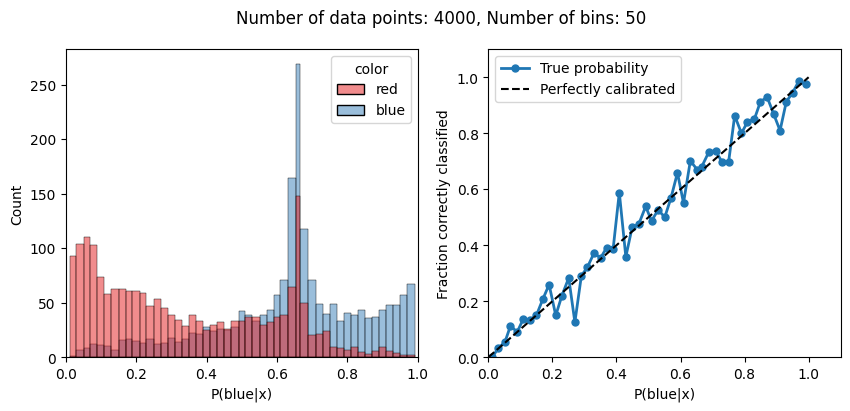

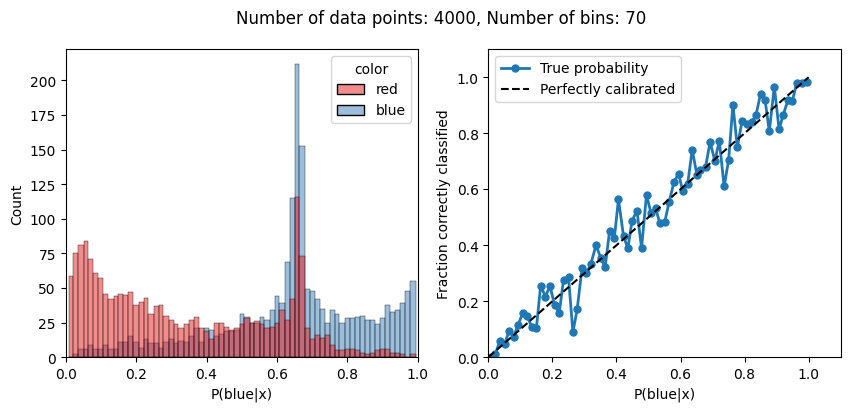

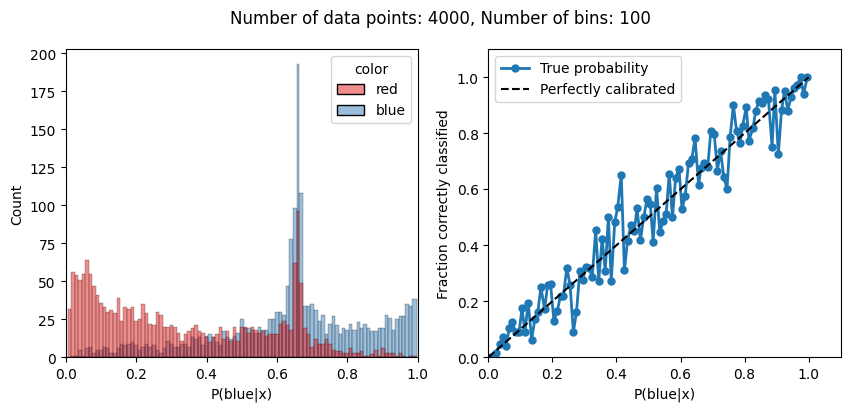

In [96]:

n_bins = [10, 20, 40, 50, 70, 100]

for i in range(len(n_bins)):
    smaller_df = test_df[0:4000]
    prob_cal, prob_pred = calibration_curve(smaller_df["Truth_value"], smaller_df["blue"], n_bins=n_bins[i], strategy="uniform")
    pred_bins=list(prob_pred)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    sn.histplot(smaller_df, x="blue", hue="color", ax=ax[0], stat="count", bins=pred_bins, palette=color)
    ax[0].set_xlim(0,1)
    ax[0].set_xlabel("P(blue|x)")
    ax[1].plot(prob_pred, prob_cal, linewidth=2, markersize=5, marker="o", label ="True probability")
    ax[1].set_xlim(0,1.1)
    ax[1].set_ylim(0,1.1)
    x = np.linspace(0, 1, 10)
    ax[1].plot(x, x, color="black", linestyle="--", label="Perfectly calibrated")
    ax[1].set_xlabel("P(blue|x)")
    ax[1].set_ylabel("Fraction correctly classified")
    ax[1].legend()
    fig.suptitle(f"Number of data points: 4000, Number of bins: {n_bins[i]}")

In [128]:

n_data = [100, 250, 500, 1000, 2000, 4000, 7000, 10000]

for i in range(len(n_data)):
    smaller_df = test_df[0:n_data[i]]
    mask_red = smaller_df["Inferred_color"] == "red"
    df_red = smaller_df[mask_red]
    prob_cal_red, prob_pred_red = calibration_curve(1 - df_red["Truth_value"], df_red["red"], n_bins=20, strategy="uniform")

    mask_blue = smaller_df["Inferred_color"] == "blue"
    df_blue = smaller_df[mask_blue]
    prob_cal_blue, prob_pred_blue = calibration_curve(df_blue["Truth_value"], df_blue["blue"], n_bins=20, strategy="uniform")
    
    prob_cal_max, prob_pred_max = calibration_curve(1 - abs(smaller_df["Truth_value"] - smaller_df["Inferred_value"]), smaller_df["Inferred_confidence"], n_bins=20, strategy="uniform")

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    sn.histplot(smaller_df, x="Inferred_confidence", hue="color", ax=ax[0], stat="count", bins=20, palette=color)
    ax[0].set_xlim(0,1)
    ax[0].set_xlabel("P(c|x)")
    ax[1].plot(prob_pred_max, prob_cal_max, linewidth=2, markersize=5, marker="o", label ="Truth predicted", color = "green")
    ax[1].plot(prob_pred_blue, prob_cal_blue, linewidth=2, markersize=5, marker="o", label ="Truth blue", color = color[1])
    ax[1].plot(prob_pred_red, prob_cal_red, linewidth=2, markersize=5, marker="o", label ="Truth red", color = color[0])
    ax[1].set_xlim(0,1.1)
    ax[1].set_ylim(0,1.1)
    x = np.linspace(0, 1, 10)
    ax[1].plot(x, x, color="black", linestyle="--", label="Perfectly calibrated")
    ax[1].set_xlabel("P(c|x)")
    ax[1].set_ylabel("Fraction correctly classified")
    ax[1].legend()
    fig.suptitle(f"Number of datapoints: {n_data[i]}")